## Boston Airbnb Market Analysis

#### The CRISP-DM method was adopted in this project. The project consists of:
##### 1) Business understanding

### Questions defined:

#### a) What drives Boston's nightly price?
#### b) What are the busiest time of the year to visit Boston? By how much do prices spike?
#### c) Can we get an idea which features are common in high demand listings?

##### 2) Data understanding: Exploratory data analysis was conducted.
##### 3) Data preparation: Data was cleaned and transformed. Some of the transformations included standardization, encoding categorical variables, feature  engineering, handling missing values, data type conversion etc.
##### 4) Modeling: Linear regression and XGBoost models were trained.
##### 5) Evaluation: Models were evaluated with metrics (RMSE and r^2) and t-tests.
##### 6) Communication: Here is my blog-post of my findings in Medium:https://medium.com/@kf092010/unlocking-bostons-airbnb-market-b190eb8edea6

In [206]:
#import libraries

import zipfile
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from datetime import datetime
import shap
from scipy import stats
from scipy.stats import ttest_rel
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

#### Data is collected from this website: https://www.kaggle.com/datasets/airbnb/boston

In [2]:
zip_path = 'C:/Users/kashfia/Videos/wfh/boston/archive.zip'  # path to ZIP file
extract_dir = 'C:/Users/kashfia/Videos/wfh/boston/extracted_csvs'  # folder to extract files into
os.makedirs(extract_dir, exist_ok=True)

In [3]:
# Extract CSV files
csv_files = []
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    for file in zip_ref.namelist():
        if file.endswith('.csv'):
            zip_ref.extract(file, extract_dir)
            csv_files.append(os.path.join(extract_dir, file))

In [4]:
# Create a separate dataframe for each file
for csv_file in csv_files:
    var_name = os.path.splitext(os.path.basename(csv_file))[0] + "_df"
    globals()[var_name]= pd.read_csv(csv_file)  
    print(var_name)

calendar_df
listings_df
reviews_df


## Explore data

In [56]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [57]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68275 entries, 0 to 68274
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     68275 non-null  int64 
 1   id             68275 non-null  int64 
 2   date           68275 non-null  object
 3   reviewer_id    68275 non-null  int64 
 4   reviewer_name  68275 non-null  object
 5   comments       68222 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.1+ MB


In [58]:
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 97 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [59]:
listings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3585.0,8.440875e+06,4.500787e+06,3.353000e+03,4.679319e+06,8.577620e+06,1.278953e+07,1.493346e+07
scrape_id,3585.0,2.016091e+13,8.516813e-01,2.016091e+13,2.016091e+13,2.016091e+13,2.016091e+13,2.016091e+13
host_id,3585.0,2.492311e+07,2.292781e+07,4.240000e+03,6.103425e+06,1.928100e+07,3.622147e+07,9.385411e+07
host_listings_count,3585.0,5.890237e+01,1.711197e+02,0.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,7.490000e+02
host_total_listings_count,3585.0,5.890237e+01,1.711197e+02,0.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,7.490000e+02
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,3585.0,4.234003e+01,2.440255e-02,4.223594e+01,4.232999e+01,4.234520e+01,4.235469e+01,4.238998e+01
longitude,3585.0,-7.108482e+01,3.156464e-02,-7.117179e+01,-7.110508e+01,-7.107843e+01,-7.106215e+01,-7.100010e+01
accommodates,3585.0,3.041283e+00,1.778929e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,3571.0,1.221647e+00,5.014871e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00


In [60]:
#unique listings
listings_df['id'].nunique()

3585

In [61]:
#unique host
listings_df['host_id'].nunique()

2181

In [62]:
# Count unique properties based on latitude and longitude
unique_properties = listings_df[['latitude', 'longitude']].drop_duplicates()
unique_properties.nunique()

latitude     3585
longitude    3585
dtype: int64

In [63]:
#find columns with missing values
def missing_columns(df):
    missing_percent = round(df.isnull().mean() * 100)
    filtered_missing = missing_percent[missing_percent > 0]# Filter columns that has missing values
    print('Number of missing columns:', filtered_missing.shape[0])
    print(filtered_missing.sort_values(ascending=False))

In [64]:
missing_columns(listings_df)

Number of missing columns: 37
neighbourhood_group_cleansed    100.0
jurisdiction_names              100.0
has_availability                100.0
license                         100.0
square_feet                      98.0
monthly_price                    75.0
weekly_price                     75.0
security_deposit                 63.0
notes                            55.0
interaction                      43.0
access                           42.0
neighborhood_overview            39.0
host_about                       37.0
transit                          36.0
house_rules                      33.0
cleaning_fee                     31.0
space                            29.0
review_scores_value              23.0
review_scores_location           23.0
review_scores_communication      23.0
review_scores_checkin            23.0
review_scores_cleanliness        23.0
review_scores_accuracy           23.0
review_scores_rating             23.0
last_review                      21.0
reviews_per_month   

In [65]:
missing_columns(calendar_df)

Number of missing columns: 1
price    51.0
dtype: float64


In [66]:
missing_columns(reviews_df)

Number of missing columns: 0
Series([], dtype: float64)


In [67]:
#Drop columns with more than 60% missing values for listings_df
threshold = 0.6
listings_df_clean = listings_df.loc[:, listings_df.isnull().mean() <= threshold]

In [68]:
listings_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 89 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [69]:
#convert price column from object to float
listings_df_clean[["price", "cleaning_fee", "extra_people"]] = listings_df_clean[["price", "cleaning_fee", "extra_people"]].replace('[\$,]', '', regex=True).astype(float)

C:\Users\kashfia\AppData\Local\Temp\ipykernel_11052\3400395101.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
# encoding categorical variables to use in price prediction
listings_df_clean=pd.get_dummies(listings_df_clean, columns=["property_type", "room_type", "host_is_superhost", "neighbourhood_cleansed"])

In [71]:
# Calculate the correlation matrix of the features
corr_matrix = listings_df_clean.corr()

In [72]:
# Ensure all rows are shown
pd.set_option('display.max_rows', None)
# Sorted from highest to lowest to find the most impactful ones.
print(corr_matrix['price'].sort_values(ascending=False))

price                                             1.000000
cleaning_fee                                      0.490210
accommodates                                      0.437756
room_type_Entire home/apt                         0.435788
bedrooms                                          0.385298
beds                                              0.370013
bathrooms                                         0.248234
guests_included                                   0.211806
latitude                                          0.196270
review_scores_location                            0.193928
host_listings_count                               0.171930
host_total_listings_count                         0.171930
longitude                                         0.165621
calculated_host_listings_count                    0.161855
review_scores_cleanliness                         0.146548
neighbourhood_cleansed_South Boston Waterfront    0.137159
neighbourhood_cleansed_Back Bay                   0.1370

In [73]:
# will not display full anymore
pd.reset_option('display.max_rows')

#### Shortlisted features

In [74]:
# following columns were selected based on correlation function
listing_df_shortlisted_columns=["price", "cleaning_fee", "accommodates", 
                                "room_type_Entire home/apt",
                              "bedrooms","bathrooms", "latitude", "longitude"]

In [75]:
# clean dataframe with shortlisted columns
listings_st_df= listings_df_clean[listing_df_shortlisted_columns]

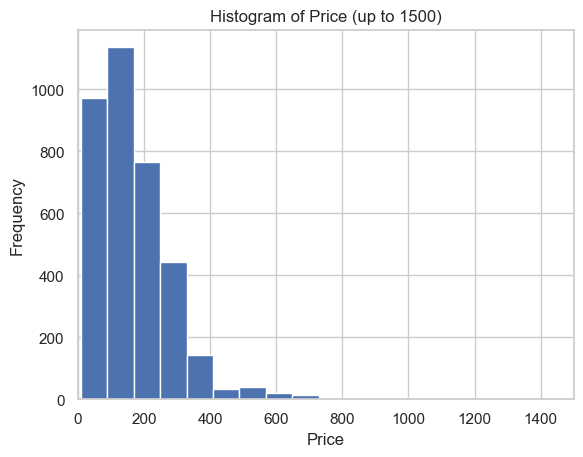

In [80]:
# Plot histogram of price with x-axis limited to 1500
listings_st_df['price'].hist(bins=50)
plt.xlim(0, 1500)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (up to 1500)')
plt.grid(True)
plt.show()

In [81]:
# Since majority price in under 400, the dataframe was filtered for better prediction
listings_st_df = listings_st_df[listings_st_df["price"] <= 400].reset_index(drop=True)

In [82]:
listings_st_df.head(5)

,price,cleaning_fee,accommodates,room_type_Entire home/apt,bedrooms,bathrooms,latitude,longitude
0,250.0,35.0,4,1,2.0,1.5,42.282619,-71.133068
1,65.0,10.0,2,0,1.0,1.0,42.286241,-71.134374
2,65.0,NaN,2,0,1.0,1.0,42.292438,-71.135765
3,75.0,50.0,4,0,1.0,1.0,42.281106,-71.121021
4,79.0,15.0,2,0,1.0,1.5,42.284512,-71.136258


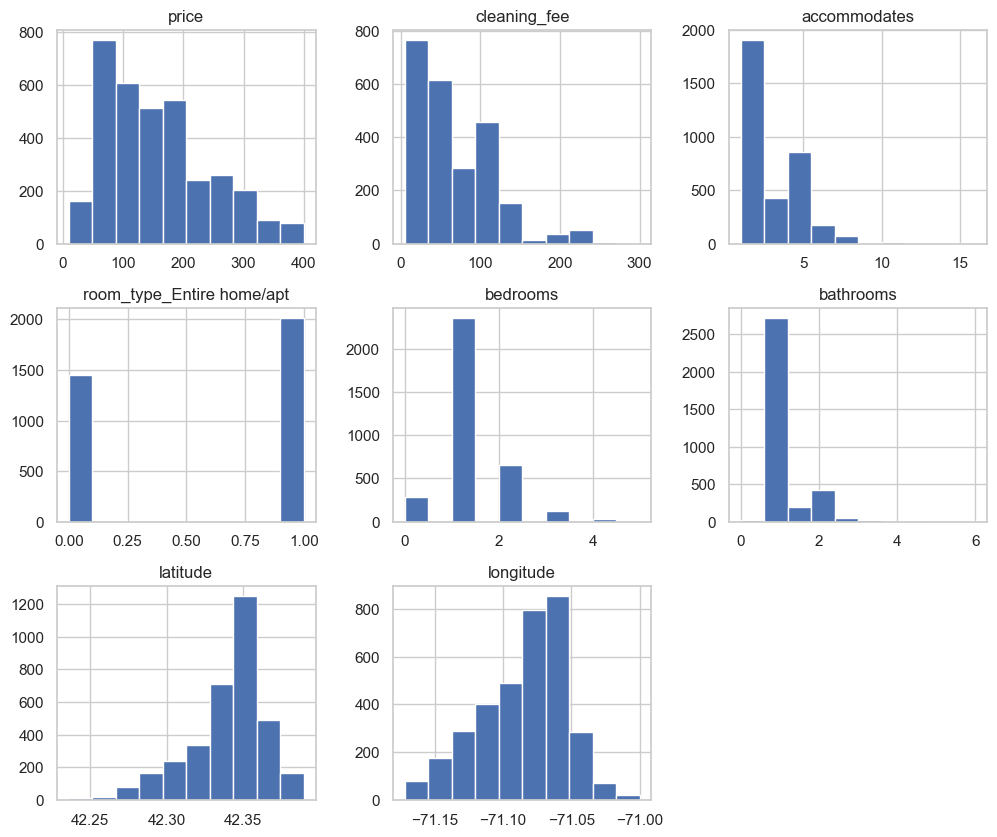

In [83]:
listings_st_df.hist(bins=10, figsize=(12, 10))
plt.show()

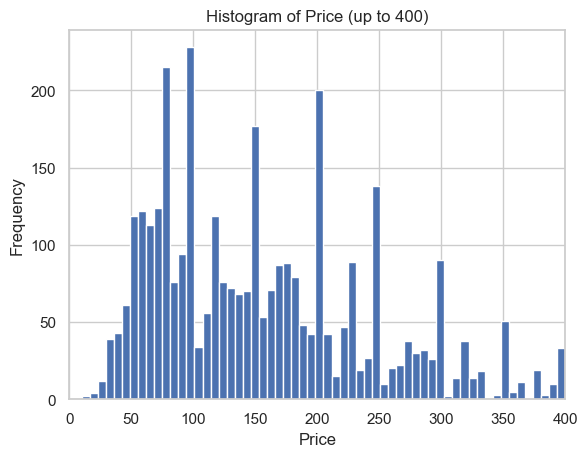

In [84]:
# Plot histogram of price with x-axis limited to 1500
listings_st_df['price'].hist(bins=60)
plt.xlim(0, 400)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (up to 400)')
plt.grid(True)
plt.show()


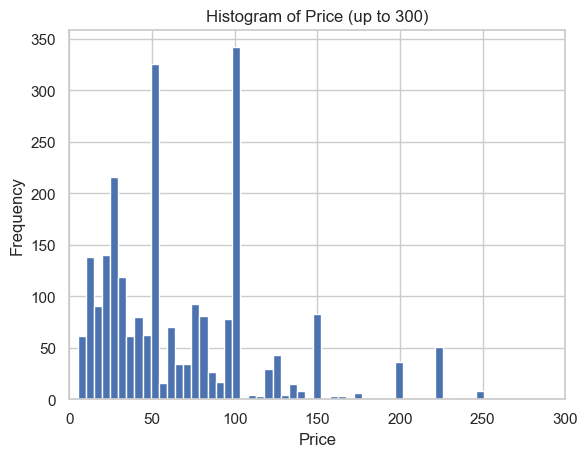

In [85]:
listings_st_df['cleaning_fee'].hist(bins=60)
plt.xlim(0, 300)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Price (up to 300)')
plt.grid(True)
plt.show()

In [86]:
#check to see any multicolinearity within the selected features
corr_matrix_sl = listings_st_df.corr()

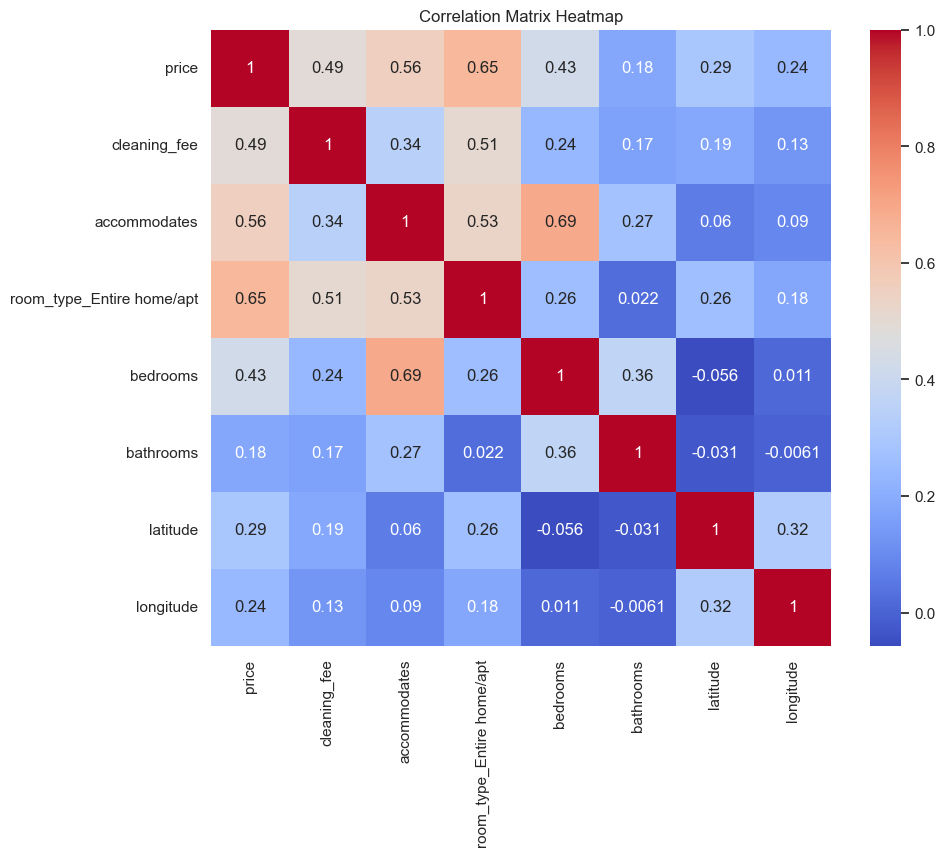

In [87]:
# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_sl, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [88]:
#columns with null values
listings_st_df.isnull().sum()

price                           0
cleaning_fee                 1073
accommodates                    0
room_type_Entire home/apt       0
bedrooms                       10
bathrooms                      14
latitude                        0
longitude                       0
dtype: int64

In [89]:
# Fill missing data for cleaning fee
listings_st_df['cleaning_fee'] = listings_st_df['cleaning_fee'].fillna(
    listings_st_df.groupby('accommodates')['cleaning_fee'].transform('median')
)

In [90]:
# Fill missing bedrooms based on median grouped by bathrooms
listings_st_df['bedrooms'] = listings_st_df['bedrooms'].fillna(
    listings_st_df.groupby('bathrooms')['bedrooms'].transform('median')
)

# Fill remaining missing bathrooms based on median grouped by bedrooms
listings_st_df['bathrooms'] = listings_st_df['bathrooms'].fillna(
    listings_st_df.groupby('bedrooms')['bathrooms'].transform('median')
)

# Fill any remaining missing bathrooms based on median beds grouped by bedrooms
# listings_st_df['beds'] = listings_st_df['beds'].fillna(
# listings_st_df.groupby('bedrooms')['beds'].transform('median')
# )

In [91]:
#columns with null values
listings_st_df.isnull().sum()

price                        0
cleaning_fee                 0
accommodates                 0
room_type_Entire home/apt    0
bedrooms                     0
bathrooms                    0
latitude                     0
longitude                    0
dtype: int64

#### Predicting price-Linear Regression

In [92]:
X=listings_st_df.drop("price", axis=1)
y=listings_st_df['price']

In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cleaning_fee               3459 non-null   float64
 1   accommodates               3459 non-null   int64  
 2   room_type_Entire home/apt  3459 non-null   uint8  
 3   bedrooms                   3459 non-null   float64
 4   bathrooms                  3459 non-null   float64
 5   latitude                   3459 non-null   float64
 6   longitude                  3459 non-null   float64
dtypes: float64(5), int64(1), uint8(1)
memory usage: 165.6 KB


In [94]:
X.describe()

,cleaning_fee,accommodates,room_type_Entire home/apt,bedrooms,bathrooms,latitude,longitude
count,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000,3459.000000
mean,59.684880,2.947095,0.581671,1.211911,1.195288,42.339843,-71.085090
std,43.620912,1.663172,0.493356,0.698604,0.467675,0.024637,0.031765
min,5.000000,1.000000,0.000000,0.000000,0.000000,42.235942,-71.171789
25%,30.000000,2.000000,0.000000,1.000000,1.000000,42.329529,-71.105593
50%,49.000000,2.000000,1.000000,1.000000,1.000000,42.345165,-71.078750
75%,80.000000,4.000000,1.000000,1.000000,1.000000,42.354741,-71.062139
max,300.000000,16.000000,1.000000,5.000000,6.000000,42.389982,-71.000100


In [95]:
# We need to standardize as there are difference in scale
binary_cols = ['room_type_Entire home/apt']
numeric_cols = [col for col in X.columns if col not in binary_cols]

In [96]:
# Standardize using StandardScaler
standard_scaler = StandardScaler()
standardized_df = pd.DataFrame(standard_scaler.fit_transform(X[numeric_cols]), columns=numeric_cols)

In [97]:
standardized_df.describe()

,cleaning_fee,accommodates,bedrooms,bathrooms,latitude,longitude
count,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03,3.459000e+03
mean,1.592090e-15,9.500608e-18,-2.437098e-16,-1.542276e-15,1.343980e-13,9.258445e-14
std,1.000145e+00,1.000145e+00,1.000145e+00,1.000145e+00,1.000145e+00,1.000145e+00
min,-1.253820e+00,-1.170881e+00,-1.735011e+00,-2.556178e+00,-4.217911e+00,-2.729758e+00
25%,-6.806179e-01,-5.695330e-01,-3.033787e-01,-4.176317e-01,-4.187005e-01,-6.455566e-01
50%,-2.449840e-01,-5.695330e-01,-3.033787e-01,-4.176317e-01,2.160756e-01,1.995945e-01
75%,4.657871e-01,6.331622e-01,-3.033787e-01,-4.176317e-01,6.048270e-01,7.226015e-01
max,5.509969e+00,7.849333e+00,5.423152e+00,1.027510e+01,2.035423e+00,2.675932e+00


In [98]:
standardized_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cleaning_fee  3459 non-null   float64
 1   accommodates  3459 non-null   float64
 2   bedrooms      3459 non-null   float64
 3   bathrooms     3459 non-null   float64
 4   latitude      3459 non-null   float64
 5   longitude     3459 non-null   float64
dtypes: float64(6)
memory usage: 162.3 KB


In [99]:
standardized_df.isnull().sum()

cleaning_fee    0
accommodates    0
bedrooms        0
bathrooms       0
latitude        0
longitude       0
dtype: int64

In [100]:
X['room_type_Entire home/apt'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3459 entries, 0 to 3458
Series name: room_type_Entire home/apt
Non-Null Count  Dtype
--------------  -----
3459 non-null   uint8
dtypes: uint8(1)
memory usage: 3.5 KB


In [101]:
X['room_type_Entire home/apt'].value_counts()

1    2012
0    1447
Name: room_type_Entire home/apt, dtype: int64

In [102]:
standardized_df['room_type_Entire home/apt']=X['room_type_Entire home/apt']

In [103]:
# Split data with these ratios: train: 0.8 | test: 0.2
X_train, X_test, y_train, y_test = train_test_split(standardized_df, y, test_size=0.2, random_state=13)

In [105]:
# Initiate and train a linear regression model on the training set
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [106]:
# Make predictions on the training and test set
linear_predictions_train = linear_model.predict(X_train)
linear_predictions_test = linear_model.predict(X_test)

In [115]:
# determine r^2 for training set
r_square_train=linear_model.score(X_train, y_train)

In [116]:
# determine r^2 for test set
r_square_test=linear_model.score(X_test, y_test)

In [117]:
# determine mean squared error value for training set
mse_train = mean_squared_error(y_train, linear_predictions_train)

In [118]:
# determine mean squared error for test set
mse_test = mean_squared_error(y_test, linear_predictions_test)

In [121]:
print('RMSE train: %.2f, test: %.2f' % (np.sqrt(mse_train),np.sqrt(mse_test)))
print('r^2 train: %.2f, test: %.2f' % (r_square_train, r_square_test))

RMSE train: 58.68, test: 55.68
r^2 train: 0.54, test: 0.58


#### Linear regression had a low r^2 score and high RMSE value. It means that linear regression although simple is not able to capture all relationship for price. We next tried to model using XGBoost (Extreme Gradient Boosting) as it build trees sequentially to correct errors from previous ones.

In [127]:
# Initiate and train XGBoost model
model_xgb = xgb.XGBRegressor()
model_xgb.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [123]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(model_xgb, X)
shap_values = explainer(X)

 99%|===================| 3435/3459 [00:33<00:00]        

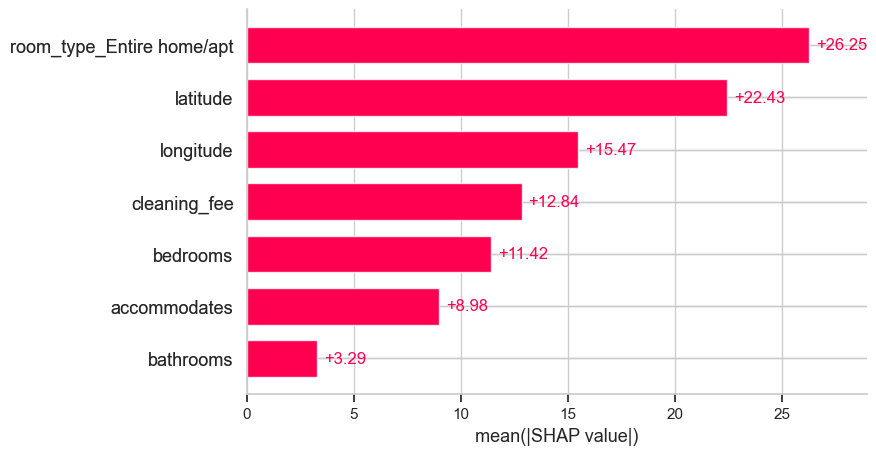

In [124]:
# Plot feature importance
shap.plots.bar(shap_values)

#### Looks like only bathroom has a low predictive power on the model prediction. So let's take it out and see how the model fits.

In [129]:
X=listings_st_df.drop("bathrooms", axis=1)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [131]:
# Initiate and train a new XGBoost model with just training data
model_xgb_s = xgb.XGBRegressor()

In [132]:
model_xgb_s.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [134]:
#calculate and print scores for the model for top 15 features
xgb_train_preds = model_xgb_s.predict(X_train)
xgb_test_preds = model_xgb_s.predict(X_test)

print('RMSE train: %.2f, test: %.2f' % (
        np.sqrt(mean_squared_error(y_train, xgb_train_preds)),
        np.sqrt(mean_squared_error(y_test, xgb_test_preds))))
print('r^2 train: %.2f, test: %.2f' % (
        r2_score(y_train, xgb_train_preds),
        r2_score(y_test, xgb_test_preds)))

RMSE train: 0.24, test: 1.01
r^2 train: 1.00, test: 1.00


#### This model is performing better in predicting price of both seen training data and unseen test data. Removing the low-impact feature bathroom has improved the model most likely by reducing model complexity and improving generalization.

In [150]:
# predictions from linear regression
linear_predictions_test[0:10]

array([106.03089309, 298.69221173, 193.77268702, 122.47569635,
       114.45963479, 190.56830724,  76.35479942, 185.21675914,
        86.24485681, 106.35700296])

In [151]:
# predictions from XGBoost
xgb_test_preds[0:10]

array([143.70328 , 395.767   , 175.0624  , 200.08049 , 175.06503 ,
       100.02153 ,  70.11637 , 120.3187  ,  49.916245, 110.040985],
      dtype=float32)

In [152]:
#Actual y-test values
y_test.head(10)

3120    144.0
645     399.0
3068    175.0
1689    200.0
114     175.0
2165    100.0
224      70.0
2680    120.0
2511     50.0
3038    110.0
Name: price, dtype: float64

#### More statistical evaluation of models.

In [157]:
#linear_predictions_test  
#xgb_test_preds     

In [167]:
# Perform paired t-test
t_stat, p_value = ttest_rel(xgb_test_preds, linear_predictions_test)

# Output the results
print(f"P-value: {p_value}")

P-value: 0.046053830593685376


#### We use t-test since we are comparing model predictions in the same dataset. And a P-value less than 0.05 shows that the model predictions differ

In [168]:
# difference between actuals and predictions for test set
errors_lr = y_test - linear_predictions_test
errors_xgb = y_test - xgb_test_preds

In [169]:
t_stat, p_value = ttest_rel(errors_xgb, errors_lr)

In [166]:
p_value

0.046053830593685376

#### Here we are comparing the errors of each model and doing a paired t-test to compare them. This tests whether the mean difference in errors between the two models is statistically significant.
#### A statistically significant p-value (typically < 0.05) suggests that XGBoost model is more accurate than linear Regression model — in terms of average error.

#### This results along with the RMSE and r^2 values indicate that the XGBoost model performs better than the linear regression model

#### In Conclusion, room type (Entire home/apt), location (latitude/longitude), cleaning fee, number of bedrooms and accomodates are the important features when determining price

#### Next we check what are the busiest time of the year to visit boston

In [173]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1308890 non-null  int64 
 1   date        1308890 non-null  object
 2   available   1308890 non-null  object
 3   price       643037 non-null   object
dtypes: int64(1), object(3)
memory usage: 39.9+ MB


In [174]:
# Convert 'dates' column to datetime
calendar_df['date'] = pd.to_datetime(calendar_df['date'])

In [175]:
#extract the week in a new column
calendar_df['week'] = calendar_df['date'].dt.isocalendar().week

In [176]:
calendar_df.head()

,listing_id,date,available,price,week
0,12147973,2017-09-05,f,NaN,36
1,12147973,2017-09-04,f,NaN,36
2,12147973,2017-09-03,f,NaN,35
3,12147973,2017-09-02,f,NaN,35
4,12147973,2017-09-01,f,NaN,35


In [177]:
#whether available or not available
calendar_df['available'].value_counts()

f    665853
t    643037
Name: available, dtype: int64

In [178]:
# function for plotting proportion of availability against week/month
def propertion_of_availability(df, col):
    counts = df.groupby(col)['available'].value_counts().unstack(fill_value=0)
    counts['proportion_available'] = counts['t'] / (counts['t'] + counts['f'])
    proportion = counts.reset_index()
    
    # Plot using seaborn
    sns.barplot(data=proportion, x=col , y='proportion_available')
    plt.title('Proportion of Availability ("t")')
    plt.ylabel('Proportion Available')
    plt.xlabel(col)
    plt.ylim(0, 1)
    plt.xticks(rotation=52)
    plt.tight_layout()
    plt.show()

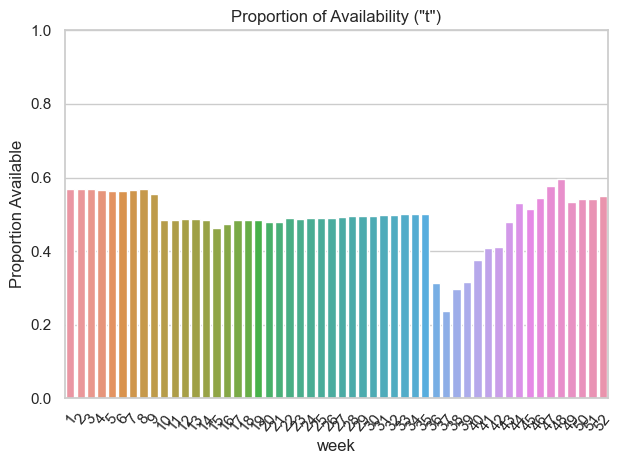

In [179]:
#plot for all weekly data
propertion_of_availability(calendar_df, 'week')

In [180]:
#bring a year column
calendar_df['year'] = calendar_df['date'].dt.isocalendar().year

In [181]:
calendar_df['year'].value_counts()

2017    885742
2016    423148
Name: year, dtype: Int64

In [182]:
#2017 year only
df_2017=calendar_df[calendar_df['year']==2017]

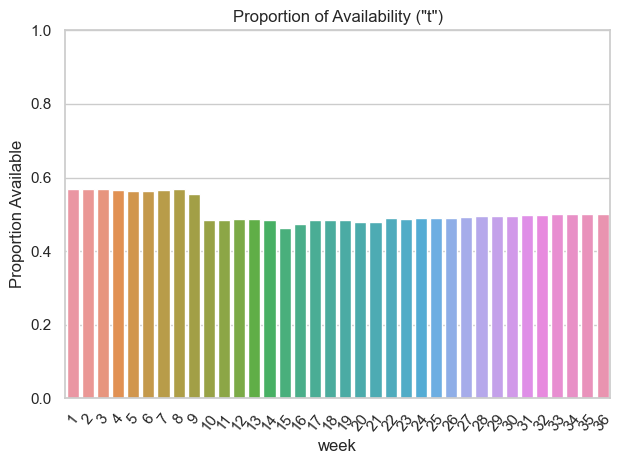

In [183]:
#plot for 2017 data
propertion_of_availability(df_2017, 'week')

In [184]:
#2016 year only
df_2016=calendar_df[calendar_df['year']==2016]

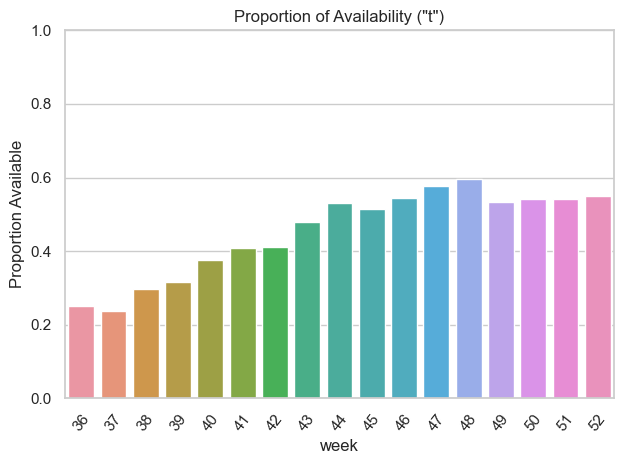

In [185]:
#plot for 2016 data
propertion_of_availability(df_2016, 'week')

In [186]:
# bring month
calendar_df['month'] = calendar_df['date'].dt.month

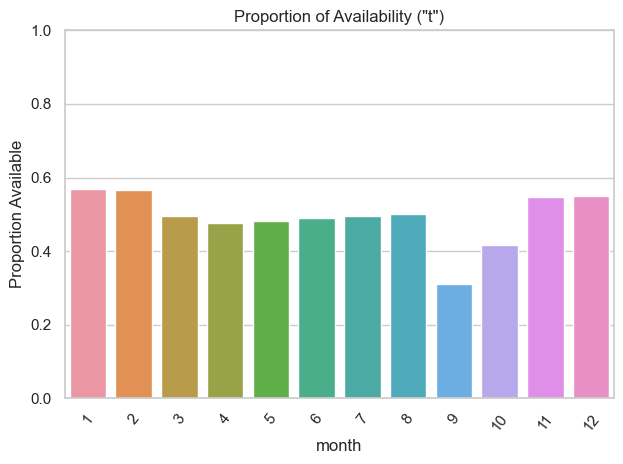

In [187]:
#plot for all monthly data
propertion_of_availability(calendar_df, 'month')

#### so there is a one year calender data in here. From here we see overall boston airbnb are busy with average availability not exceeding 60% in any month,  with the peak demand being in the month of september and october most likely due to fall color. From march till August also we see less availability, most likely due to spring and summer months.

#### By how much do prices spike?

In [188]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308890 entries, 0 to 1308889
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   listing_id  1308890 non-null  int64         
 1   date        1308890 non-null  datetime64[ns]
 2   available   1308890 non-null  object        
 3   price       643037 non-null   object        
 4   week        1308890 non-null  UInt32        
 5   year        1308890 non-null  UInt32        
 6   month       1308890 non-null  int64         
dtypes: UInt32(2), datetime64[ns](1), int64(2), object(2)
memory usage: 62.4+ MB


In [189]:
#calender df with price present
price_df = calendar_df[calendar_df['price'].notnull()]

In [190]:
# convert price from object to float
price_df.price=price_df.price.replace('[\$,]', '', regex=True).astype(float)

C:\Users\kashfia\AppData\Local\Temp\ipykernel_11052\84920891.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643037 entries, 365 to 1308879
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   listing_id  643037 non-null  int64         
 1   date        643037 non-null  datetime64[ns]
 2   available   643037 non-null  object        
 3   price       643037 non-null  float64       
 4   week        643037 non-null  UInt32        
 5   year        643037 non-null  UInt32        
 6   month       643037 non-null  int64         
dtypes: UInt32(2), datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 35.6+ MB


In [196]:
# function for plotting the average price per month or week
def average_price(df, col):
    avg = df.groupby(col)['price'].mean().reset_index()

    # Plot using seaborn
    sns.barplot(data=avg, x=col, y='price')
    plt.title('Average price by ' + col)
    plt.ylabel('Average price')
    plt.xlabel(col)
    #plt.ylim(0, 250)
    plt.yticks(ticks=range(0, 271, 15))
    plt.xticks(rotation=52)
    plt.tight_layout()
    plt.show()

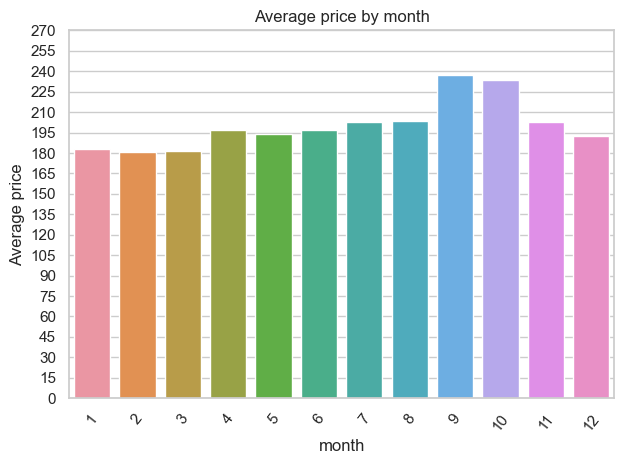

In [197]:
#average price per month
average_price(price_df, 'month')

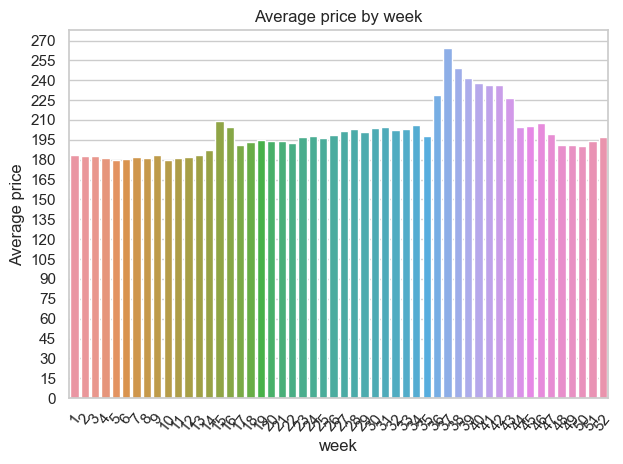

In [207]:
#average price per week
average_price(price_df, 'week')

#### We see highest price hike in fall with peak weeks having 50-80 dollars hike it coincides with the low availability that we were seeing earlier. Interestingly summer months have only a modest price hike whereas I had expected high price hike there as well.

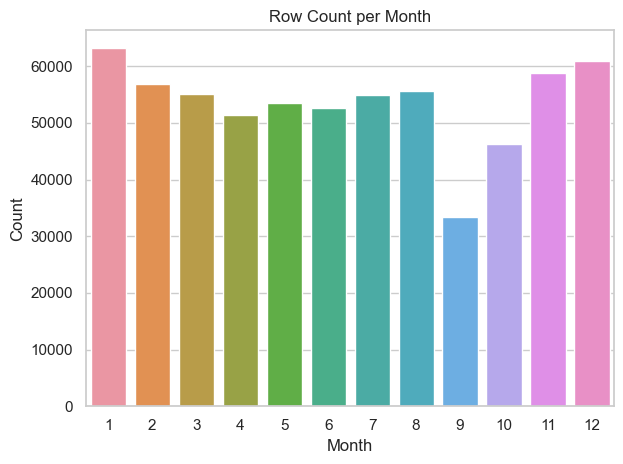

In [199]:
#spread of data in price_df
# Count number of rows per month
monthly_counts = price_df['month'].value_counts().sort_index().reset_index()
monthly_counts.columns = ['month', 'count']

# Plot using seaborn
sns.barplot(data=monthly_counts, x='month', y='count')
plt.title('Row Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

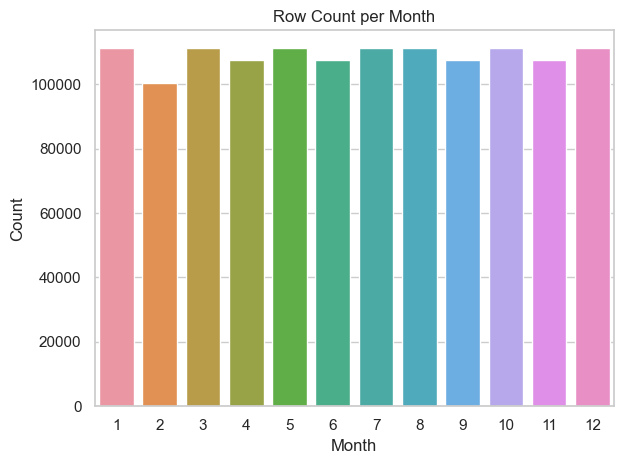

In [200]:
#spread of data in calender_df
# Count number of rows per month
monthly_counts = calendar_df['month'].value_counts().sort_index().reset_index()
monthly_counts.columns = ['month', 'count']

# Plot using seaborn
sns.barplot(data=monthly_counts, x='month', y='count')
plt.title('Row Count per Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

#### Can we get an idea which features are common in high demand listings?

In [201]:
listings_df['availability_30'].dtype

dtype('int64')

In [202]:
# convert price from object to float
listings_df['price']=listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

In [203]:
# when availability of 30 days is less than 5, that listing is in high demand
listings_df['Demand_type'] = np.where(listings_df['availability_30'] <= 5.0, 'high_demand', 'low_demand')

In [204]:
listings_df['Demand_type'].value_counts()

high_demand    2003
low_demand     1582
Name: Demand_type, dtype: int64

In [205]:
# Remove outliers using IQR
Q1 = listings_df['price'].quantile(0.25)
Q3 = listings_df['price'].quantile(0.75)
IQR = Q3 - Q1
outlier_removed_df = listings_df[
    (listings_df['price'] >= Q1 - 1.5 * IQR) &
    (listings_df['price'] <= Q3 + 1.5 * IQR) #keeps only rows within that price range
]

# Create box plot
fig = px.box(
    outlier_removed_df,
    x='room_type',
    y='price',
    color='Demand_type',
    title='Price Distribution by Room Type and Demand Type',
    labels={
        'room_type': 'Room Type',
        'price': 'Price (USD)',
        'Demand_type': 'Demand Type'
    }
)

# Show plot
fig.show()

#### The plot shows that high-demand listings tend to have lower median prices than low-demand ones across room types. With the highest difference observed when renting entire home/apt. The spread of prices is also generally tighter for high-demand listings.
